In [1]:
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# !pip3 install gensim
!pip3 install --upgrade pyLDAvis


In [ ]:
import os
import time
import math
from pprint import pprint
from textblob import TextBlob
import pandas as pd
import numpy as np
from pandarallel import pandarallel

import matplotlib.pyplot as plt


import nltk as nltk
from nltk.corpus import stopwords
import spacy
spacy.load("en_core_web_sm")
import multiprocessing
import string


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pandarallel import pandarallel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [4]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
workers = num_processors-1
print(f'Available CPUs: {num_processors}')

Available CPUs: 16


In [5]:
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [6]:
%%time

df = pd.read_parquet('nlp_clean_text.parquet')
df.shape

CPU times: user 3.99 s, sys: 2.48 s, total: 6.47 s
Wall time: 6.36 s


(184488, 3)

In [8]:
df.head()

,date,clean_title,clean_text
0,2020-01-28,auckland.scoop.co.nz » AUT boosts AI expertise...,auckland.scoop.co.nz » AUT boosts AI expertise...
1,2021-03-18,Artificial intelligence improves parking effic...,Artificial intelligence improves parking effic...
2,2020-02-26,LegalTech Artificial Intelligence Market 2019 ...,LegalTech Artificial Intelligence Market 2019 ...
3,2020-02-27,Children With Autism Saw Their Learning and So...,Children With Autism Saw Their Learning and So...
4,2021-07-05,"Observation, Simulation, And AI Join Forces To...","Observation, Simulation, And AI Join Forces To..."


In [ ]:
#Detect major topics

In [9]:
df["clean_title"].str.split().str.len().describe()

count    184488.000000
mean         15.206165
std           9.364707
min           2.000000
25%          11.000000
50%          14.000000
75%          18.000000
max        1726.000000
Name: clean_title, dtype: float64

In [10]:
df["clean_text"].str.split().str.len().describe()

count    184488.000000
mean        879.810676
std         762.942127
min           5.000000
25%         467.000000
50%         737.000000
75%        1110.000000
max       35165.000000
Name: clean_text, dtype: float64

In [7]:
%%time
# Tokenize text into words and remove punctuation
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_list = df['clean_text'].tolist()        
data_tokens = list(sent_to_words(data_list))

CPU times: user 9min 28s, sys: 11.3 s, total: 9min 40s
Wall time: 9min 40s


In [8]:
%%time
bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 15min 11s, sys: 5.05 s, total: 15min 16s
Wall time: 15min 16s


In [9]:
%%time
stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

CPU times: user 5.1 ms, sys: 75 µs, total: 5.17 ms
Wall time: 25.8 ms


In [ ]:
# !python3 -m spacy download en_core_web_sm

In [10]:
%%time
# Remove Stop Words
data_tokens_nostops = remove_stopwords(data_tokens)

# Create n-grams
data_words_bigrams = make_bigrams(data_tokens_nostops)
data_words_trigrams = make_trigrams(data_tokens_nostops)

# Combine tokens and n-grams
# data_tokens_cobnined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
data_tokens_cobnined = data_words_trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_tokens_cobnined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(*data_lemmatized[:1])

CPU times: user 1h 26min 32s, sys: 28.3 s, total: 1h 27min 1s
Wall time: 1h 27min 1s


In [13]:
# import pickle

# # Save data_lemmatized as a file using pickle
# with open('data_lemmatized.pkl', 'wb') as f:
#     pickle.dump(data_lemmatized, f)

In [6]:
import pickle

# Load data_lemmatized from the saved file
with open('data_lemmatized.pkl', 'rb') as f:
    data_lemmatized = pickle.load(f)

In [7]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(data_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

In [ ]:
#Build initial 3 topic model
# num_processors = multiprocessing.cpu_count()
# workers = num_processors-1

# lda_model = LdaMulticore(corpus=doc_term_matrix,
#                    id2word=dictionary,
#                    num_topics=3,
#                    random_state=100,
#                    passes=10,
#                    alpha='symmetric',
#                    eta='auto',
#                    workers=workers)

In [ ]:
# Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', coherence_lda)

In [8]:
# Tune LDA model
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [9]:
%%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')
alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')
beta = ['auto'] # Run for number of topics only

# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [doc_term_matrix]

corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        
                     
lda_tuning = pd.DataFrame(model_results)

LDA will execute 9 iterations
Completed model based on 2 LDA topics. Finished 11.1% of LDA runs
Completed model based on 3 LDA topics. Finished 22.2% of LDA runs
Completed model based on 4 LDA topics. Finished 33.3% of LDA runs
Completed model based on 5 LDA topics. Finished 44.4% of LDA runs
Completed model based on 6 LDA topics. Finished 55.6% of LDA runs
Completed model based on 7 LDA topics. Finished 66.7% of LDA runs
Completed model based on 8 LDA topics. Finished 77.8% of LDA runs
Completed model based on 9 LDA topics. Finished 88.9% of LDA runs
Completed model based on 10 LDA topics. Finished 100.0% of LDA runs
CPU times: user 1h 7min 2s, sys: 19min 43s, total: 1h 26min 45s
Wall time: 1h 44min 40s


In [ ]:
# %%time
# grid = {}
# grid['Validation_Set'] = {}
# # Topics range
# min_topics = 2
# max_topics = 10
# step_size = 1
# topics_range = range(min_topics, max_topics+1, step_size)

# # Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')


# # Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')


# # Validation sets
# num_of_docs = len(doc_term_matrix)
# corpus_sets = [doc_term_matrix]
# corpus_title = ['100% Corpus']
# model_results = {
#                  'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }

# itr = 0
# itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
# print(f'LDA will execute {itr_total} iterations')

    
# # iterate through hyperparameters
# for i in range(len(corpus_sets)):
#     # iterate through number of topics
#     for k in topics_range:
#         # iterate through alpha values
        
#         for a in alpha:
#             # iterare through beta values
#             for b in beta:
#                 # get the coherence score for the given parameters
#                 itr += 1
#                 cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
#                                               k=k, a=a, b=b)
#                 # Save the model results
#                 model_results['Topics'].append(k)
#                 model_results['Alpha'].append(a)
#                 model_results['Beta'].append(b)
#                 model_results['Coherence'].append(cv)
#                 pct_completed = round((itr / itr_total * 100),1)
# #                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
#         print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        
                     
# lda_tuning = pd.DataFrame(model_results)

In [10]:
lda_tuning.to_csv("lda_topics.csv")

In [11]:
lda_tuning.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Alpha,Beta,Coherence
2,4,asymmetric,auto,0.353301
8,10,asymmetric,auto,0.334632
4,6,asymmetric,auto,0.333292
3,5,asymmetric,auto,0.332701
7,9,asymmetric,auto,0.330314
6,8,asymmetric,auto,0.329250
5,7,asymmetric,auto,0.326765
1,3,asymmetric,auto,0.319941
0,2,asymmetric,auto,0.293856


<AxesSubplot:title={'center':'Overall LDA Tuning'}, xlabel='Topics'>

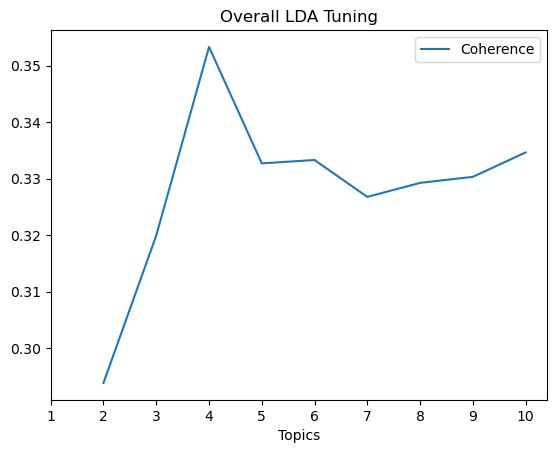

In [12]:

lda_tuning.plot(x ='Topics', y='Coherence', title = 'Overall LDA Tuning',kind = 'line', xticks=range(1,11))

In [13]:
lda_tuning_best = lda_tuning.sort_values(by=['Coherence'], ascending=False).head(1)


tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))


# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()
    

try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 4, Alpha: asymmetric, Beta: auto


In [14]:
lda_model_4 = LdaMulticore(corpus=doc_term_matrix,
                   id2word=dictionary,
                   num_topics=4,
                   random_state=100,
                   passes=10,
                   alpha='asymmetric',
                   eta='auto',
                   workers=workers)

In [15]:
lda_display = gensimvis.prepare(lda_model_4, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)